# Machine Learning II Project

Group Members:
- Daniel Kruk
- Marcelo Junior <br>

# Customer Segmentation <br>
The main goal of this notebook is to identify relevant customer segments using clustering algorithms. <br>
In order to do so, we will use the data from the Preprocessing notebook, which has already been cleaned and prepared for this task, and scale it, so as to not bias the clustering algorithms, alongside applying PCA to reduce the dimensionality of the data. <br>
The data used is the same as the one used in the Preprocessing notebook. <br>
The notebook is divided into the following sections:
1. Libraries
2. Importing the Data
3. Scaling
4. PCA
5. Clustering
6. Conclusion

The clustering algorithms used are:
* K-Means
* Hierarchical Clustering
* DBSCAN
* Mean Shift
* HDBSCAN

The evaluation metrics that will be used are:
* Silhouette Score
* Confusion Matrix
* UMAP
* Domain Knowledge




## Libraries
Firstly, we will import the needed libraries:

In [2]:
# If needed to install these libraries, uncomment the following lines
#!pip install umap-learn
#!pip install hdbscan

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.decomposition import PCA
from umap import UMAP
import hdbscan

from utils import (
    visualise_cluster, combine_cluster_results, find_best_params,
    run_clustering)

from plot_automation import ( 
    auto_umap, plot_hierarchical_dendrogram, plot_dendrogram)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=073db93f89c2e6a0c0e30071398015ccd2425ccabc644d71beca91a2c0c19aae
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=7b0eda0591118952b1ee4afe3c6147bd9f9bc095c69181bdba0a6d65ea4f8c8b
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

Because some of the algorithms used required some parameters tuning, the following variable will be used to control whether or not to run the loops that will be used to find these best parameters.

In [3]:
run_loops = False

## Importing the Data

In [4]:
customer_info_ppc = pd.read_csv("Project Data/Customer Info PPC.csv")

In [5]:
customer_info_ppc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29774 entries, 0 to 29773
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customer_id                              29774 non-null  int64  
 1   customer_name                            29774 non-null  object 
 2   highest_education                        29774 non-null  int64  
 3   customer_gender                          29774 non-null  int64  
 4   Age                                      29774 non-null  int64  
 5   kids_home                                29774 non-null  float64
 6   teens_home                               29774 non-null  float64
 7   number_complaints                        29774 non-null  float64
 8   distinct_stores_visited                  29774 non-null  float64
 9   lifetime_spend_groceries                 29774 non-null  float64
 10  lifetime_spend_electronics               29774

Because the algorithms will not handle strings, we will drop `customer_name`, alongside the identifiers `loyalty_card_number` and `customer_id`.

In [6]:
# Remove the identifiers
customer_info_seg = customer_info_ppc.drop(['loyalty_card_number', 'customer_name', 'customer_id'], axis = 1)

In [7]:
customer_info_seg

,highest_education,customer_gender,Age,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_videogames,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,has_loyalty_card,total_minors,total_spending,lifetime_spend_tech
0,0,0,23,0.0,0.0,0.0,2.0,91.0,20.0,22.0,...,105.0,85.0,0.192154,2017.0,38.754263,-9.163397,0,0.0,1545.0,125.0
1,0,1,41,1.0,0.0,0.0,2.0,197.0,5958.0,21.0,...,1964.0,85.0,0.098647,2015.0,38.777761,-9.156197,0,1.0,10219.0,7922.0
2,3,0,36,1.0,1.0,0.0,20.0,397.0,20.0,9.0,...,5.0,408.0,0.497251,2008.0,38.785329,-9.127113,0,2.0,1753.0,25.0
3,0,0,80,3.0,4.0,1.0,2.0,5282.0,237.0,12.0,...,1078.0,1956.0,0.206713,2010.0,38.744086,-9.156589,0,7.0,11195.0,1315.0
4,0,0,23,0.0,0.0,0.0,2.0,82.0,22.0,21.0,...,103.0,83.0,0.200625,2015.0,38.756024,-9.162970,0,0.0,1370.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29769,3,0,48,0.0,0.0,1.0,2.0,209.0,5474.0,20.0,...,1984.0,112.0,0.096366,2008.0,38.734446,-9.171911,1,0.0,9730.0,7458.0
29770,0,1,37,0.0,0.0,0.0,3.0,185.0,1066.0,15.0,...,197.0,22.0,0.118998,2014.0,38.767070,-9.144301,0,0.0,2416.0,1263.0
29771,0,1,22,0.0,0.0,0.0,2.0,83.0,23.0,23.0,...,94.0,77.0,0.199432,2016.0,38.728487,-9.164140,1,0.0,1491.0,117.0
29772,0,1,64,1.0,0.0,1.0,20.0,391.0,20.0,10.0,...,5.0,398.0,0.494527,2006.0,38.751123,-9.182512,0,1.0,1608.0,25.0


## Scaling

Because some variables, as said previously, have a much higher range than others, we will scale the data using StandardScaler.

In [8]:
# Scale the data with Standard Scaler
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_info_seg)

With the data scaled, it was decided to use PCA to reduce the dimensionality of the data, as it will be easier to visualize and will also help the clustering algorithms. This will be done in the next section.

## PCA
In this section, the Principal Component Analysis will be done. <br>
Firstly, we will plot the explained variance ratio for each component, so as to find the optimal number of components to use.

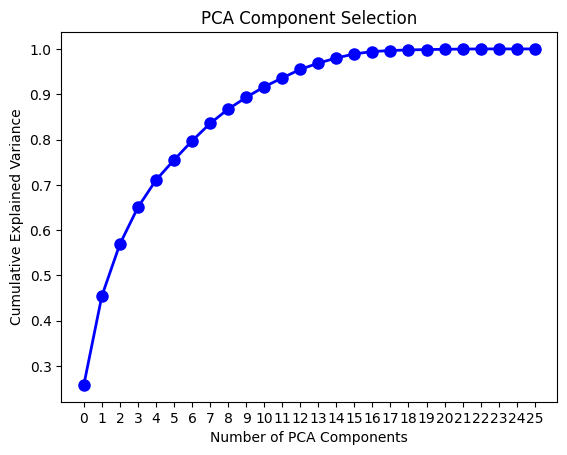

In [9]:
# Create the PCA object
pca = PCA()

# Fit the PCA object to the scaled data with all the components
pca_all = pca.fit(customer_scaled)

# Transform the scaled data with all the components
components = pca_all.transform(customer_scaled)

# Plot cumulative explained variance ratio
plt.plot(
    pca_all.explained_variance_ratio_.cumsum(),
    '-o', 
    markersize=8,
    color='blue',
    linewidth=2,
)
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Component Selection')
plt.xticks(range(len(pca_all.explained_variance_ratio_)))
plt.show()

The chosen number of components will be 5, as it is the lowest number of components that gives at least 70% of the explained variance.


In [10]:
# Choose the number of components which gives at least 70%
n_components = 5

# Perform PCA with the selected number of components
pca_5 = PCA(n_components=n_components)

customer_info_pca_fit = pca_5.fit(customer_scaled)

customer_info_pca = pca_5.transform(customer_scaled)

Having done this, it is now possible to see the explained variance ratio for each component.

In [11]:
customer_info_pca_fit.explained_variance_ratio_

array([0.25810155, 0.19646506, 0.11451413, 0.08119358, 0.06008373])

We can see that the first component explains 25,8% of the variance, the second 19,6%, the third 11,5%, the fourth 8,1% and the fifth 6%. <br>
The next step is to see which variables have the highest influence in each component.

In [12]:
pc_components = pd.DataFrame(
    customer_info_pca_fit.components_.T, 
    columns = ['PC'+str(i) for i in range(0,5)], 
    index=customer_info_seg.columns)

# Only one sort will be shown, but all were done
pc_components.sort_values('PC0')

,PC0,PC1,PC2,PC3,PC4
year_first_transaction,-0.252975,0.034542,0.211001,0.101630,0.273084
lifetime_spend_electronics,-0.113117,0.392544,-0.076009,0.020767,-0.209070
lifetime_spend_tech,-0.094443,0.408045,-0.023498,0.051656,-0.186345
percentage_of_products_bought_promotion,-0.048336,-0.189508,-0.173019,0.535881,0.081355
lifetime_spend_videogames,-0.040189,0.410303,0.107775,0.123116,-0.114042
distinct_stores_visited,-0.019998,-0.232912,-0.264939,0.424639,-0.075603
typical_hour,-0.006344,0.346695,0.068481,-0.004498,0.283848
customer_gender,-0.002267,-0.001890,0.002876,0.005274,-0.014167
longitude,0.009847,-0.000802,0.016291,0.000845,-0.215149
latitude,0.021430,-0.004841,0.037424,0.008997,-0.308778


Here we can see how each variable affects the principal components. <br>
* In PC0, *lifetime_spend_meat* and *lifetime_spend_fish* have the highest positive influence, whereas *year_first_transaction* has the most negative influence. We could call them **Meat Eaters**. <br>
* For PC1, *lifetime_spend_videogames* has the highest positive influence and *lifetime_spend_vegetables* the most negative one. These would be the **Gamers**.
* Now for PC2, we have that *total_minors* is has the biggest positive coefficient and *distinct_stores_visited*, with *percentage_of_products_bought_promotion* also close, the most negative one, even if not much. These are the **Loyal Families**.
* Regarding PC3, *percentage_of_products_bought_promotion* has the highest coefficient, followed closely by *distinct_stores_visited*, with *lifetime_spend_vegetables* and *highest_education* having the lowest negative values. This would be the **Uneducated Store Hoppers**.
* Finally, PC4 has *lifetime_spend_alcohol_drinks* as its positive highest coefficient and *Age*
 the lowest, thus they are **Young Alcoholics**.

These names are not to be taken seriously, they are just a way to better understand the data. They are also not mutually exclusive, as a customer can be a Meat Eater and a Gamer, for example, as they do not represent clusters, but rather the influence of each variable in each component. <br>
With this done, the next step is to try as many clustering algorithms as possible and see which one gives the best results.



# Clustering
In this section, the clustering algorithms will be applied to the data.
Algorithms learned in class will be used, as well as some others that were not covered. The first ones will not be explained in detail, as they were already covered in class.

## 1. K-Means

### 1.1. Choosing the number of clusters with the Elbow Method

In [72]:
# Apply k-means clustering with different number of clusters and store the dispersion
dispersion = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = 'auto').fit(customer_info_pca)
    dispersion.append(kmeans.inertia_)

With the dispersion for each number of clusters found, it is now possible to plot the graph and see which number of clusters is the best.

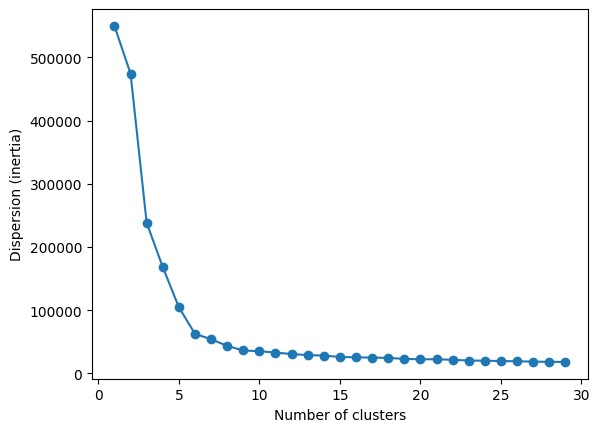

In [73]:
plt.plot(range(1, 30), dispersion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.show()

From this graph, it is possible to see that most gains are made up to 6 clusters, with minimal gains after 9 clusters. These 2 options can be considered for the algorithm. <br>
Some grain of salt must be taken, as the Elbow Method is not a perfect method, but it is a good way to get a general idea of the number of clusters to use. 6 clusters in particular seem to be quite few for the data, but it will be considered nonetheless. <br>

In [15]:
# Apply k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=6, random_state = 0)
kmeans9 = KMeans(n_clusters=9, random_state = 0)

# Fit the k-means objects to the data
kmeans.fit(customer_info_pca)
kmeans9.fit(customer_info_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=9, random_state=0)

### 1.2. Predicting the clusters
With the number of clusters chosen, it is now possible to predict the clusters for each customer and store them in the dataframe.

In [16]:
customer_info_seg['cluster_kmeans'] = kmeans.predict(customer_info_pca)
customer_info_seg['cluster_kmeans9'] = kmeans9.predict(customer_info_pca)

### 1.3. Checking the results

In [86]:
customer_info_seg.groupby(['cluster_kmeans']).mean().T

cluster_kmeans,0,1,2,3,4,5
highest_education,1.000660,0.187993,1.008894,0.707185,0.938324,0.806614
customer_gender,0.498460,0.509525,0.505857,0.500418,0.507504,0.497969
Age,55.532130,55.893400,55.509111,55.414160,56.194180,32.843551
kids_home,3.152289,0.972292,0.689588,0.995823,1.084553,0.222588
teens_home,1.853213,0.094670,0.068547,0.271094,0.754941,0.142332
number_complaints,0.934639,1.196844,0.500000,1.548037,0.341691,0.170180
distinct_stores_visited,3.008363,18.993073,1.992625,7.974102,1.995059,2.466254
lifetime_spend_groceries,4997.344850,297.491437,200.406291,14942.928571,940.039898,3383.760588
lifetime_spend_electronics,199.936620,19.563979,4999.557484,199.954052,117.703148,637.835622
typical_hour,17.402729,9.046565,20.951844,11.929407,9.943082,18.649584


In [85]:
customer_info_seg.groupby(['cluster_kmeans9']).mean().T

cluster_kmeans9,0,1,2,3,4,5,6,7,8
highest_education,0.190634,0.701784,1.008894,1.008252,0.972359,1.571062,1.029873,0.000000,0.363248
customer_gender,0.509073,0.500105,0.505857,0.509733,0.488830,0.490582,0.514937,0.499204,0.502137
Age,55.688585,55.414900,55.509111,55.184511,54.248391,29.089897,57.049114,22.217357,52.546581
kids_home,0.978732,0.997692,0.689588,1.160178,2.171905,0.164812,4.367089,0.017516,0.513248
teens_home,0.089561,0.271563,0.068547,0.771689,1.218099,0.005565,2.649114,0.001592,0.516239
number_complaints,1.181268,1.550892,0.500000,0.310622,0.927679,0.039812,0.942278,0.000796,0.559402
distinct_stores_visited,19.245463,7.998531,1.992625,2.000212,3.010602,3.001712,3.004557,1.999204,1.967521
lifetime_spend_groceries,298.749659,14991.233998,200.406291,997.313796,4999.661871,6917.913955,4994.059241,104.001592,597.722222
lifetime_spend_electronics,19.596293,199.970829,4999.557484,50.157215,199.920485,985.687072,200.037975,23.061306,582.911966
typical_hour,9.032585,11.915845,20.951844,9.983496,17.431655,18.936644,17.348354,21.604299,13.697863


### 1.4. Visualising the results

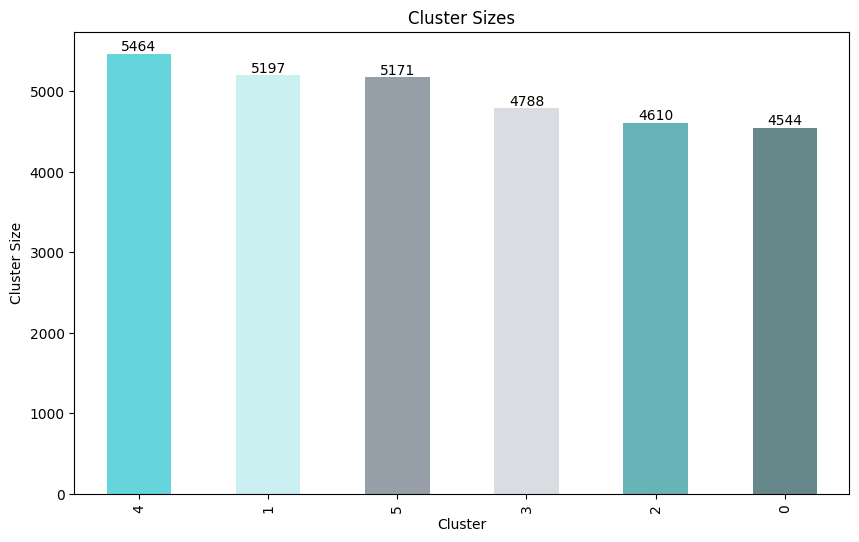

In [74]:
visualise_cluster(customer_info_seg,'cluster_kmeans' )

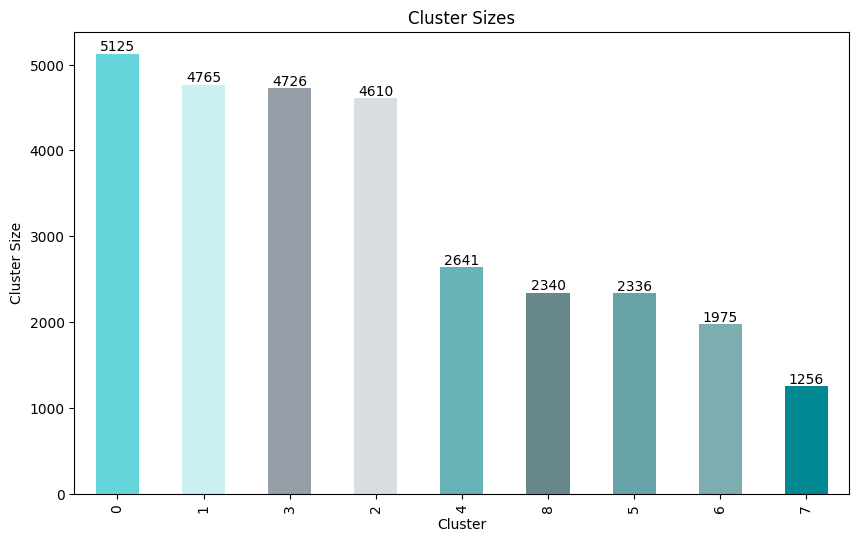

In [75]:
visualise_cluster(customer_info_seg,'cluster_kmeans9' )

## 2. Hierarchical Clustering

### 2.1. Choosing the number of clusters with the Silhouette Score
One of the metrics that can be used to choose the number of clusters is the Silhouette Score. This metric measures how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to 1, with 1 being the best score and -1 the worst. <br>

In [121]:
# Complete and Single linkage will not be considered for computational reasons and
# because they had the worst results
# Define a list of linkage methods to test
linkage_methods = ['ward', 'average']
n_clusters_range = range(5, 11)

run_clustering(linkage_methods, n_clusters_range, customer_info_pca, run_loops)

The clusters that will be considered are the ones with the highest silhouette score for each linkage method, alongside the ones chosen in K-Means, so as to have a comparison between the two algorithms. These are: <br>
Ward: <br> 
6 clusters: based on the silhouette score and K-Means<br>
7 clusters: based on the silhouette score <br>
9 clusters: based on K-Means <br>
Average: <br>
7 clusters: based on the silhouette score<br>
8 clusters: based on the silhouette score
 <br>

<br>




One of the things that jumps out is both 6 and 9 clusters being chosen for Ward linkage, similar to K-Means. This could be seen as a good sign, as it means that the algorithms are in agreement. <br>

### 2.2. Choosing the number of clusters with the Dendrogram
Another way to choose the number of clusters is to use the dendrogram. This is a tree-like diagram that shows the order in which clusters are merged. The height of the dendrogram at a given point shows the distance between the clusters that are being merged. <br>

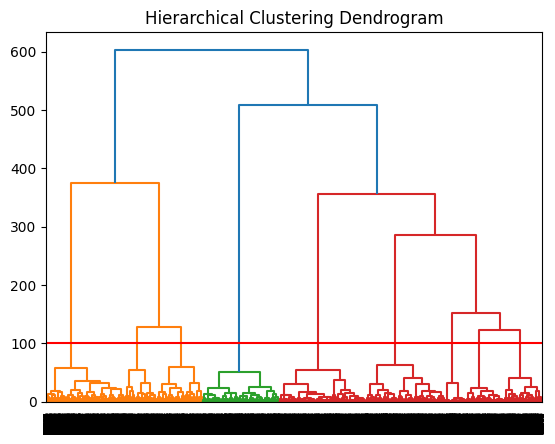

In [115]:
plot_hierarchical_dendrogram(
    linkage='ward', distance_threshold=0.0, n_clusters=None,
    title="Hierarchical Clustering Dendrogram", line=100, p=0
)

It can be seen that, while using 6 clusters could have seemed optimal, some of those cluster would have quite distinct points, particularly what would have been the 4th cluster. 7 clusters could also suffer from this problem. When using 9 clusters, the clusters have less intra-cluster distance while preserving a higher inter-cluster distance, which could be seem as a better solution, though it might be more difficult to identify and distinguish the clusters. A final middle of the road solution could be 8 clusters, which would be a compromise between the two. <br>

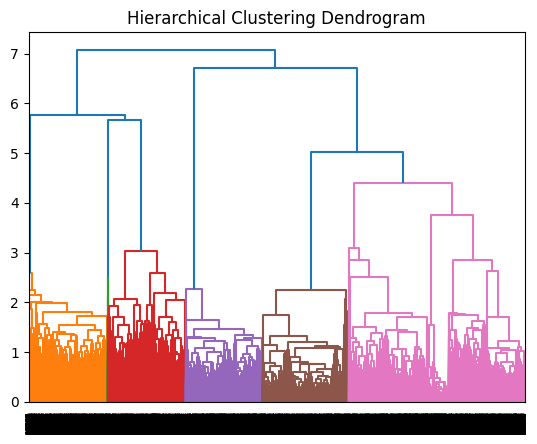

In [24]:
plot_hierarchical_dendrogram(
    linkage='ward', distance_threshold=0.0, n_clusters=None,
    title="Hierarchical Clustering Dendrogram", line=3, p=0
)

In comparison to its Ward counterpart, this hierarchical solutions seems much less optimal, with clusters being more difficult to be identified and not as distinct. From a visual standpoint, 8 clusters would have seemed to be the best from this, but it is hardly comparable to the solutions with Ward. As such, it will not be considered. <br>

Based on the previous results, the Ward linkage method will be used with 6, 8 and 9 clusters.

In [25]:
# Create an instance of the AgglomerativeClustering algorithm for each number of clusters
hierarchical = AgglomerativeClustering(n_clusters=6, linkage='ward')
hierarchical8 = AgglomerativeClustering(n_clusters=8, linkage='ward')
hierarchical9 = AgglomerativeClustering(n_clusters=9, linkage='ward')

# Fit the models to the data
hierarchical.fit(customer_info_pca)
hierarchical8.fit(customer_info_pca)
hierarchical9.fit(customer_info_pca)

AgglomerativeClustering(n_clusters=9)

### 2.3. Predicting the clusters

In [26]:
customer_info_seg['cluster_hierarchical_W6'] = hierarchical.fit_predict(customer_info_pca)
customer_info_seg['cluster_hierarchical_W8'] = hierarchical8.fit_predict(customer_info_pca)
customer_info_seg['cluster_hierarchical_W9'] = hierarchical9.fit_predict(customer_info_pca)

### 2.4. Analysing the clusters

#### Ward with 6 clusters

##### Cluster Sizes

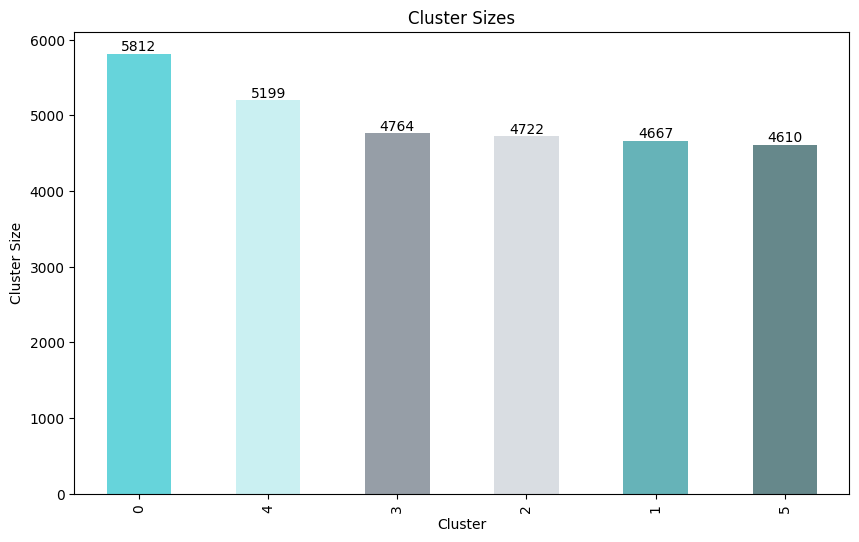

In [76]:
visualise_cluster(customer_info_seg,'cluster_hierarchical_W6' )

##### Cluster Means

In [27]:
customer_info_seg.groupby(['cluster_hierarchical_W6']).mean().T

cluster_hierarchical_W6,0,1,2,3,4,5
highest_education,0.771507,0.995715,1.007624,0.701511,0.187921,1.008894
customer_gender,0.496387,0.499893,0.509530,0.500210,0.509713,0.505857
Age,36.391776,55.351189,55.167302,55.410369,55.916522,55.509111
kids_home,0.268582,3.078852,1.160525,0.997901,0.972879,0.689588
teens_home,0.202684,1.811656,0.771495,0.271620,0.096557,0.068547
number_complaints,0.206469,0.933576,0.310885,1.551008,1.194845,0.500000
distinct_stores_visited,2.392980,3.007285,2.000212,7.999580,18.986921,1.992625
lifetime_spend_groceries,2998.446490,4997.018856,997.551461,14993.307935,297.735911,200.406291
lifetime_spend_electronics,633.773744,200.006642,50.036637,199.970403,19.828429,4999.557484
typical_hour,17.518926,17.401971,9.988564,11.914568,9.043085,20.951844


#### Ward with 8 clusters

##### Cluster Sizes

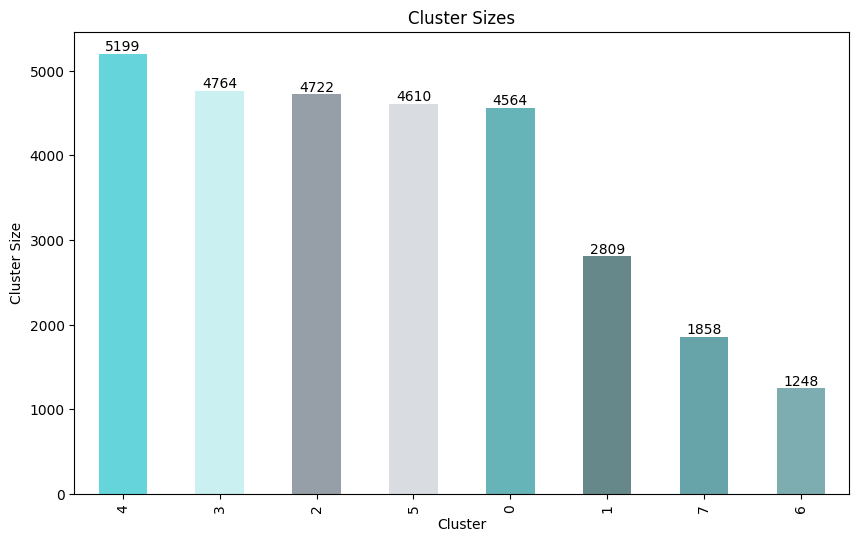

In [77]:
visualise_cluster(customer_info_seg,'cluster_hierarchical_W8' )

##### Cluster Means

In [28]:
customer_info_seg.groupby(['cluster_hierarchical_W8']).mean().T


cluster_hierarchical_W6,0,1,2,3,4,5
highest_education,0.771507,0.995715,1.007624,0.701511,0.187921,1.008894
customer_gender,0.496387,0.499893,0.509530,0.500210,0.509713,0.505857
Age,36.391776,55.351189,55.167302,55.410369,55.916522,55.509111
kids_home,0.268582,3.078852,1.160525,0.997901,0.972879,0.689588
teens_home,0.202684,1.811656,0.771495,0.271620,0.096557,0.068547
number_complaints,0.206469,0.933576,0.310885,1.551008,1.194845,0.500000
distinct_stores_visited,2.392980,3.007285,2.000212,7.999580,18.986921,1.992625
lifetime_spend_groceries,2998.446490,4997.018856,997.551461,14993.307935,297.735911,200.406291
lifetime_spend_electronics,633.773744,200.006642,50.036637,199.970403,19.828429,4999.557484
typical_hour,17.518926,17.401971,9.988564,11.914568,9.043085,20.951844


##### Cluster Sizes

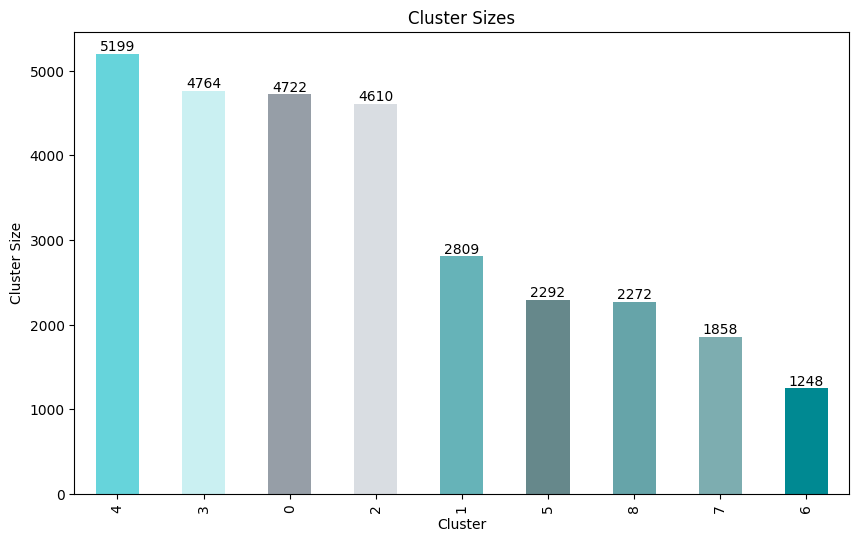

In [78]:
visualise_cluster(customer_info_seg,'cluster_hierarchical_W9' )

##### Cluster Means

In [29]:
customer_info_seg.groupby(['cluster_hierarchical_W9']).mean().T

cluster_hierarchical_W9,0,1,2,3,4,5,6,7,8
highest_education,1.007624,1.003560,1.008894,0.701511,0.187921,0.387435,0.000000,0.983854,1.582746
customer_gender,0.509530,0.487362,0.505857,0.500210,0.509713,0.500000,0.500801,0.518837,0.490317
Age,55.167302,55.030260,55.509111,55.410369,55.916522,51.769634,22.176282,55.836383,28.687060
kids_home,1.160525,2.233891,0.689588,0.997901,0.972879,0.510908,0.016026,4.356297,0.162852
teens_home,0.771495,1.214311,0.068547,0.271620,0.096557,0.513962,0.000000,2.714747,0.000000
number_complaints,0.310885,0.933072,0.500000,1.551008,1.194845,0.505236,0.000000,0.934338,0.018486
distinct_stores_visited,2.000212,3.010680,1.992625,7.999580,18.986921,1.995637,2.000000,3.002153,3.009683
lifetime_spend_groceries,997.551461,5000.432538,200.406291,14993.307935,297.735911,611.212478,100.346955,4991.857912,6998.608715
lifetime_spend_electronics,50.036637,199.986828,4999.557484,199.970403,19.828429,602.317190,19.899038,200.036598,1002.705986
typical_hour,9.988564,17.437878,20.951844,11.914568,9.043085,13.868237,21.606571,17.347686,18.956426


As could have been guessed, 6 clusters seem to little as not many patters are seen, as more distant points have been combined into single clusters. Particularly, the younger cluster has a mean age of around 37 years, with young people not being properly represented as seen before. <br>
As thought before, the 8 clusters solution seems to be a good compromise between the 6 and 9 clusters solutions, with the clusters being more distinct and with more patterns being seen. <br>
This will be the solution that will be used for the rest of the analysis. <br>

### 2.5. Comparing the hierarchical and K-Means solutions

Comparing the Ward solution with the K-Means with 6 clusters.

In [98]:
# Use the funciton imported from utils
combine_cluster_results(customer_info_seg.cluster_kmeans, customer_info_seg.cluster_hierarchical_W8,
                        'K-Means', 'Ward')

,Ward 0,Ward 1,Ward 2,Ward 3,Ward 4,Ward 5,Ward 6,Ward 7
K-Means 0,0,2686,0,0,0,0,0,1858
K-Means 1,12,0,0,0,5185,0,0,0
K-Means 2,0,0,0,0,0,4610,0,0
K-Means 3,0,24,0,4764,0,0,0,0
K-Means 4,728,0,4722,0,14,0,0,0
K-Means 5,3824,99,0,0,0,0,1248,0


In [99]:
combine_cluster_results(customer_info_seg.cluster_kmeans9, customer_info_seg.cluster_hierarchical_W8,
                        'K-Means', 'Ward')

,Ward 0,Ward 1,Ward 2,Ward 3,Ward 4,Ward 5,Ward 6,Ward 7
K-Means 0,0,0,0,0,5125,0,0,0
K-Means 1,0,1,0,4764,0,0,0,0
K-Means 2,0,0,0,0,0,4610,0,0
K-Means 3,4,0,4722,0,0,0,0,0
K-Means 4,0,2515,0,0,0,0,0,126
K-Means 5,2286,50,0,0,0,0,0,0
K-Means 6,0,243,0,0,0,0,0,1732
K-Means 7,8,0,0,0,0,0,1248,0
K-Means 8,2266,0,0,0,74,0,0,0


## 3. Mean Shift

### 3.1. Finding the optimal bandwidth
One of the main parameters of the Mean Shift algorithm is the bandwidth, which is the radius of the area around each point that will be considered when calculating the density. <br>
Because estimate_bandwidth() did not yield a good result, the bandwidth will be found by iterating over a range of values and calculating the silhouette score for each one. The bandwidth that yields the highest silhouette score will be considered the optimal one. <br>

In [106]:
# Grid search for MeanShift
bandwidth_values = [2.2, 2.5, 2.7]

# Use bin_seeding to make it faster
mean_shift_params = [{'bandwidth': bandwidth, 'bin_seeding': True} for bandwidth in bandwidth_values]

# Get best parameters
find_best_params(run_loops, MeanShift, mean_shift_params)

Best parameter combination: {'bandwidth': 2.2, 'bin_seeding': True}


The best bandwidth was found to be 2.2. Even though bin_seeding was used for the grid search, the clustering algorithm will not use it, as there is no need for more speed at this point. <br>

### 3.2. Predicting the clusters

In [33]:
customer_info_seg['cluster_meanshift'] = MeanShift(bandwidth = 2.2).fit_predict(customer_info_pca)

### 3.3. Analysing the clusters

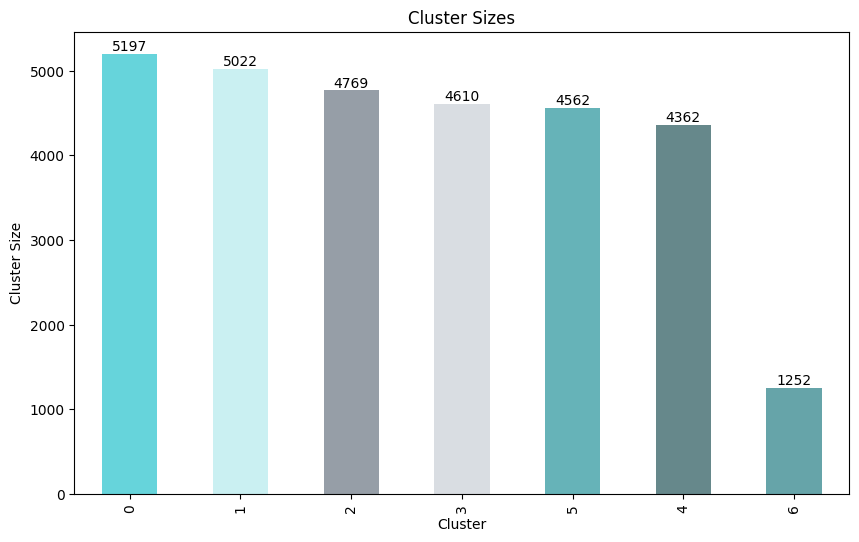

In [79]:
visualise_cluster(customer_info_seg,'cluster_meanshift' )

In [35]:
customer_info_seg.groupby(['cluster_meanshift']).mean().T

cluster_meanshift,0,1,2,3,4,5,6
highest_education,0.188185,0.977300,0.702873,1.008894,1.008712,1.001754,0.000000
customer_gender,0.509332,0.508562,0.500105,0.505857,0.496561,0.499781,0.499201
Age,55.892630,55.783751,55.407633,55.509111,38.789088,55.498685,22.185304
kids_home,0.971907,1.129630,0.997274,0.689588,0.317515,3.142262,0.017572
teens_home,0.095247,0.770211,0.271336,0.068547,0.225585,1.847655,0.001597
number_complaints,1.197422,0.324771,1.550430,0.500000,0.255617,0.934459,0.000000
distinct_stores_visited,18.992688,1.997810,7.993919,1.992625,2.549289,3.008549,2.000799
lifetime_spend_groceries,297.359823,972.967145,14982.935836,200.406291,4040.203347,4997.260851,102.581470
lifetime_spend_electronics,19.464114,76.877738,199.973789,4999.557484,809.102476,199.928759,21.289137
typical_hour,9.046758,9.824970,11.914867,20.951844,17.045851,17.405962,21.595847


## 4. DBScan

### 4.1. Finding the optimal parameters
The DBScan algorithm has two main parameters: epsilon and min_samples. <br>
Epsilon is the radius of the area around each point that will be considered when calculating the density. <br>
Min_samples is the minimum number of points that must be within the radius of a point for it to be considered a core point. <br>
So as to find the optimal parameters, the silhouette score will be calculated for a range of values for each parameter. The combination of parameters that yields the highest silhouette score will be considered the optimal one. <br>

In [110]:
# Grid search for DBSCAN
epsilon_values = [0.7, 0.9, 1.0, 1.2, 1.5]
min_samples_values = [200, 250, 300, 350, 400]
dbscan_params = [{'eps': eps, 'min_samples': min_samples} for eps
                 in epsilon_values for min_samples in min_samples_values]

find_best_params(run_loops, DBSCAN, dbscan_params)

Best parameter combination: {'eps': 1.0, 'min_samples': 300}


The best parameters were found to be epsilon = 1 and min_samples = 300. <br>

### 4.2. Predicting the clusters

In [37]:
customer_info_seg['cluster_dbscan'] = DBSCAN(eps=1, min_samples=300).fit_predict(customer_info_pca)


### 4.3. Analysing the clusters

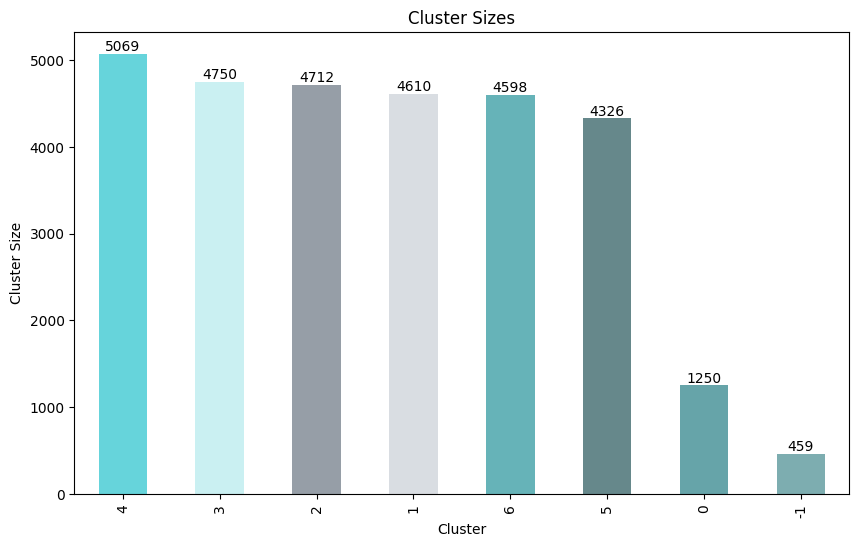

In [81]:
visualise_cluster(customer_info_seg,'cluster_dbscan' )

In [40]:
customer_info_seg.groupby(['cluster_dbscan']).mean().T

cluster_dbscan,-1,0,1,2,3,4,5,6
highest_education,1.061002,0.000000,1.008894,1.008065,0.701263,0.192740,0.972492,0.969117
customer_gender,0.520697,0.500000,0.505857,0.509338,0.499789,0.508187,0.499538,0.496303
Age,59.424837,22.182400,55.509111,55.160866,55.395368,55.507595,55.281091,40.551109
kids_home,3.546841,0.016000,0.689588,1.154075,0.997263,0.981653,2.973185,0.339495
teens_home,2.583878,0.000000,0.068547,0.766766,0.270105,0.082067,1.705270,0.260331
number_complaints,1.572985,0.000800,0.500000,0.310272,1.551368,1.134149,0.933195,0.279687
distinct_stores_visited,2.753813,1.999200,1.992625,1.999576,7.999368,19.447031,3.008553,2.487386
lifetime_spend_groceries,4215.771242,101.336800,200.406291,997.045628,14994.284211,299.816335,4996.997688,3765.794693
lifetime_spend_electronics,178.000000,20.776000,4999.557484,50.119694,199.973684,19.704084,200.096625,793.765768
typical_hour,15.235294,21.607200,20.951844,9.982385,11.914526,9.024068,17.430421,16.354284


Cluster 0 and 5 seems to be quite the same, which indicates that this clustering method is not the most adequate for the problem at hand. As such, even though it found some patterns, it will not be considered for the final mode and no further analysis will be done on it. <br>
Unique to the DBScan when compared to the other algorithms, 459 customers did not fit into a clusters given the constraints.

### 5. Clustering Analysis with UMAP and HDbscan
The UMAP algorithm is a dimensionality reduction technique that can be used to reduce the dimensionality of the data before clustering. This approach is interesting because it allows to reduce the dimensionality of the data without losing as much information as with PCA. <br>

The HDBScan algorithm identifies groups or clusters in a dataset based on their density. It explores the density of points and detects regions of high density separated by areas of low density. By considering the density of points, HDBScan can uncover clusters of varying shapes and sizes, making it a versatile tool for data analysis and pattern recognition tasks. Its ability to uncover clusters without prior assumptions or knowledge about the data makes it a valuable algorithm in exploratory data analysis.

### 5.1. Visualising previous solutions with UMAP

In [41]:
# Store the cluster labels
ward8 = customer_info_seg['cluster_hierarchical_W8']
kmeans_labesls = customer_info_seg['cluster_kmeans']
kmeans9_labels = customer_info_seg['cluster_kmeans9']
ms_labels = customer_info_seg['cluster_meanshift']
dbs_labels = customer_info_seg['cluster_dbscan']

customer_seg_nolabels = customer_info_seg.drop(['cluster_kmeans', 'cluster_kmeans9',
                                                             'cluster_hierarchical_W8', 'cluster_meanshift',
                                                             'cluster_dbscan'], axis = 1).copy()
# Create the main UMAP object
umap_object = UMAP(random_state=0)

umap_ppc = umap_object.fit_transform(customer_seg_nolabels)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


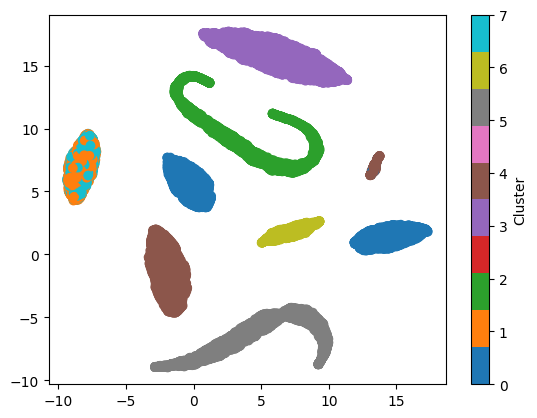

In [50]:
# Ward 8
auto_umap(ward8, umap_ppc)

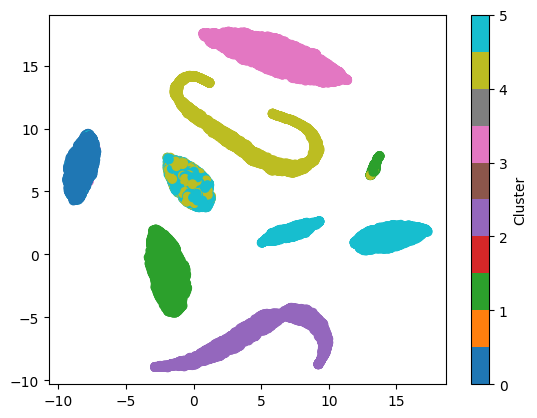

In [51]:
# K-Means 6
auto_umap(kmeans_labesls, umap_ppc)

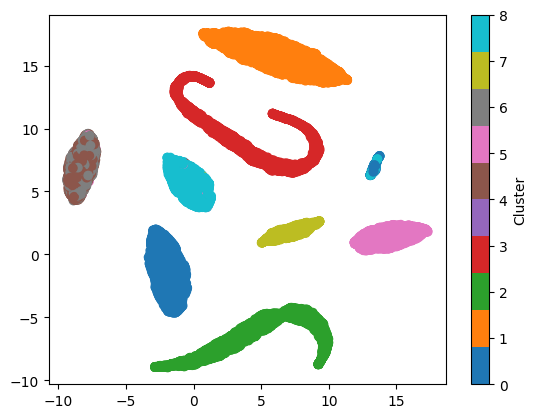

In [52]:
# K-Means 9
auto_umap(kmeans9_labels, umap_ppc)

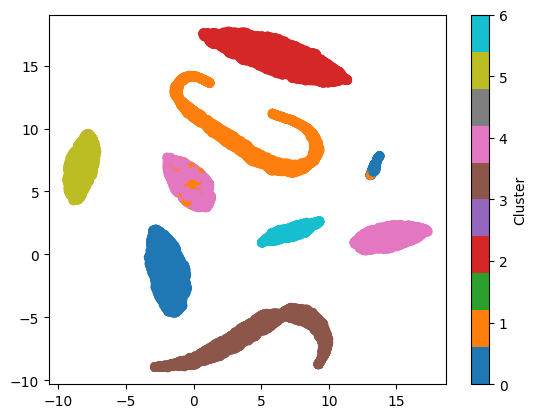

In [53]:
# Mean Shift
auto_umap(ms_labels, umap_ppc)

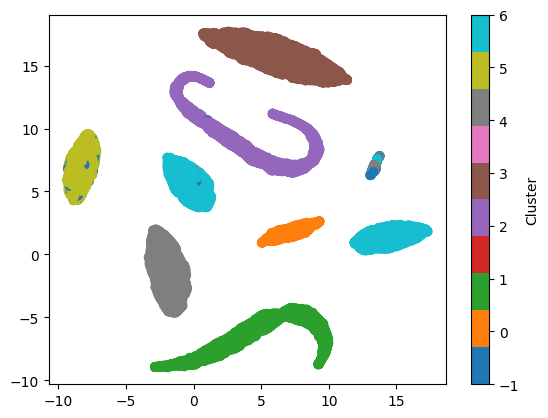

In [54]:
# DBScan
auto_umap(dbs_labels, umap_ppc)

Having analysed the UMAPs, it seems that no algorithm was able to find an optimal clustering solution. Some small outliers can be found, whose cluster varies solution by solution. As such, the UMAP will be used to reduce the dimensionality of the data before applying the HDBScan algorithm. <br>

### 5.2. Applying HDBScan
The first step is to reduce the dimensionality of the data using UMAP. <br>
No scaling nor PCA is needed because the UMAP algorithm is not affected by the scale of the data. <br>

In [57]:
clusterable_embedding = UMAP(
    min_dist=0.0,
    n_components=2,
    random_state=0,
).fit_transform(customer_seg_nolabels)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


#### 5.2.1. Predicting the clusters

In [58]:
customer_info_seg['cluster_hdbscan'] = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=1000,
).fit_predict(clusterable_embedding)

#### 5.2.2. Analysing the clusters

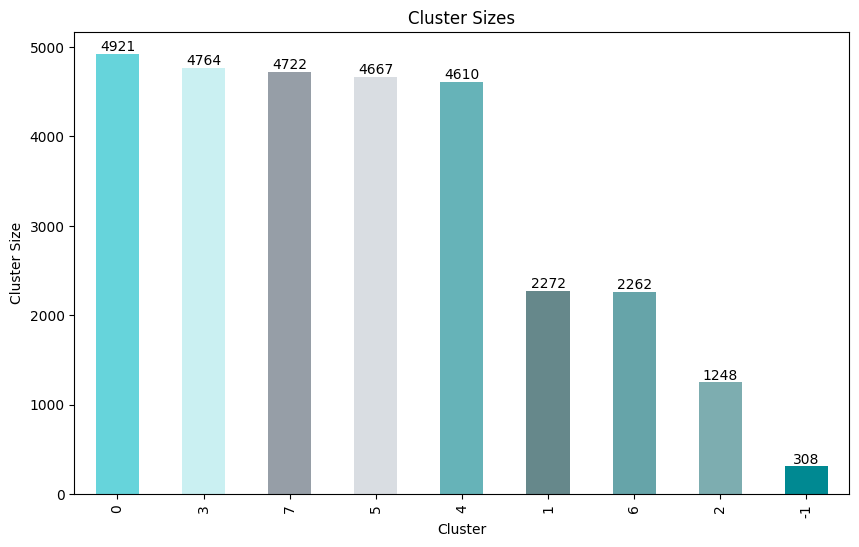

In [65]:
visualise_cluster(customer_info_seg,'cluster_hdbscan' )

In [66]:
customer_info_seg.groupby(['cluster_hdbscan']).mean().T

cluster_hdbscan,-1,0,1,2,3,4,5,6,7
highest_education,0.019481,0.198537,1.582746,0.000000,0.701511,1.008894,0.995715,0.389920,1.007624
customer_gender,0.522727,0.508433,0.490317,0.500801,0.500210,0.505857,0.499893,0.500884,0.509530
Age,70.571429,55.062792,28.687060,22.176282,55.410369,55.509111,55.351189,51.576481,55.167302
kids_home,0.474026,1.000203,0.162852,0.016026,0.997901,0.689588,3.078852,0.513263,1.160525
teens_home,0.548701,0.069904,0.000000,0.000000,0.271620,0.068547,1.811656,0.515915,0.771495
number_complaints,4.139610,1.010567,0.018486,0.000000,1.551008,0.500000,0.933576,0.496021,0.310885
distinct_stores_visited,1.000000,20.001829,3.009683,2.000000,7.999580,1.992625,3.007285,2.011494,2.000212
lifetime_spend_groceries,199.211039,302.959764,6998.608715,100.346955,14993.307935,200.406291,4997.018856,617.420866,997.551461
lifetime_spend_electronics,9.948052,20.000000,1002.705986,19.899038,199.970403,4999.557484,200.006642,611.014589,50.036637
typical_hour,10.048701,8.991668,18.956426,21.606571,11.914568,20.951844,17.401971,13.907162,9.988564


### 5.3. Visualising the clusters

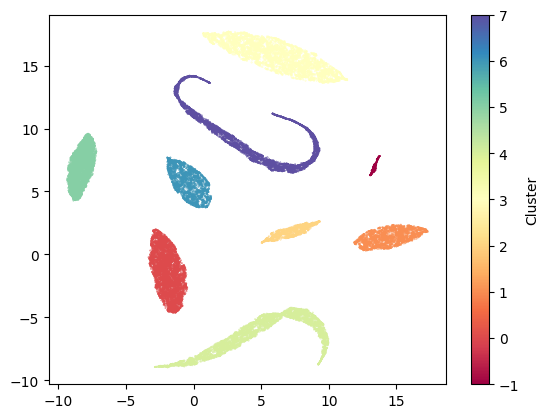

In [60]:
clustered = (customer_info_seg['cluster_hdbscan'].values >= -1)
plt.scatter(umap_ppc[~clustered, 0],
            umap_ppc[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(umap_ppc[clustered, 0],
            umap_ppc[clustered, 1],
            c=customer_info_seg['cluster_hdbscan'].values[clustered],
            s=0.1,
            cmap='Spectral')
plt.colorbar(label='Cluster')


The results of the HDBScan are impressive, as it was able to find all the different clusters from the UMAP while identifying the outliers. <br>
As such, this will be the clustering method used for the final model, also considering how well it found the patterns in the data. <br>

### 6. Final Clustering
With the final clustering method chosen, the next step identify and describe the clusters. <br>
The names used will be explained in the report. <br>

In [67]:
customer_info_ppc['cluster_hdbscan'] = customer_info_seg['cluster_hdbscan']

In [68]:
# Define the cluster names and -1 label
cluster_names = {
    -1: 'Golden Oldies',
    0: 'Promo Seekers',
    1: 'Young&Rich',
    2: 'Young Alcoholics',
    3: 'Loyals',
    4: 'Geeks',
    5: 'Family Friendly',
    6: 'Bang-Average Consumers',
    7: 'Green Beans'
}

# Iterate over the cluster names dictionary and replace the values in the DataFrame
for cluster, name in cluster_names.items():
    customer_info_ppc['cluster_hdbscan'] = customer_info_ppc['cluster_hdbscan'].replace(cluster, name)


### 6.1. Adding back the Supermarkets

In [71]:
supermarkets = pd.read_csv('Project Data/Supermarket Info.csv')
supermarkets['cluster_hdbscan'] = 'Supermarket'

full_customer = pd.concat([customer_info_ppc, supermarkets], axis = 0)

### 6.2 Visualising the Clusters

In [ ]:
visualise_cluster(full_customer,'cluster_hdbscan' )

With the addition of the Supermarkets, and considering Golden Oldies (or -1) as a cluster, with it not being the smallest cluster anymore, the final clustering solution has 10 clusters.

### 6.3. Exporting the Data
Finally, the data will be exported to a CSV file for the Association Rules. <br>

In [84]:
full_customer.to_csv('Project Data/Full Clustered Final.csv', index = False)